## **Cervical Cancer Classification**

<br></br>
<h3><b> Loading Python Libraries </b></h3>

In [1]:
import numpy as np
import pandas as pd
from typing import List
import missingno as msno
from sklearn.svm import SVC
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from plotly.subplots import make_subplots
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler


<br></br>
### **Importing the Data**

In [2]:
# Let's fetch the youtube spam comments dataset into a data_frame
cancer_dataframe = pd.read_csv('risk_factors_cervical_cancer.csv')



# Let's take a quick look at the shape of the dataframe
print("Cancer Risk factors data shape -->", cancer_dataframe.shape)
print()

# Let's take a brief look at the contents of the dataframe
cancer_dataframe.head().style.background_gradient()

Cancer Risk factors data shape --> (858, 36)



,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,?,?,0,0,0,0,0,0,0,0


<br></br>
<h3><b> Gaining Insights from Data </b></h3>

In [3]:
# Let's obtain a brief overview of the dataframe
cancer_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

In [4]:
# Let's see descriptive statistics for all numeric columns
cancer_dataframe.describe()

,Age,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,0.087413,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,0.302545,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<b><h4>Observations</h4></b>
1. **The dataset mainly covers young pepople with an average age of approximately 26.82 years, yet with a broad age spectrum (13 to 84 years).**
2. **Diagnosed conditions and positive test outcomes for STDs, cancer, HPV, and related health screenings are remarkably low, with most participants having zero diagnoses, reflecting either a generally healthy population or limited diagnostic testing among the subjects.**

<br></br>
### **Data Cleaning and Processing**

In [5]:

# Let's identify columns of type object
object_cols = cancer_dataframe.select_dtypes(include=["object"]).columns
cancer_dataframe[object_cols] = cancer_dataframe[object_cols].apply(pd.to_numeric, errors="coerce")

# Let's fill NaN values with np.nan
cancer_dataframe[object_cols].fillna(np.nan, inplace=True)

# Initialize the SimpleImputer to replace missing values with the median of each column
imp = SimpleImputer(strategy="median")

# Let's fit the imputer and transform the data, imputing missing values
X = imp.fit_transform(cancer_dataframe)
cancer_dataframe = pd.DataFrame(X, columns=cancer_dataframe.columns)

<ipython-input-5-85b3a7dd27b4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_dataframe[object_cols].fillna(np.nan, inplace=True)


In [6]:
def categorize_age(age):
    """
    Categorize age into predefined age groups.
    """
    if age < 12:
        category = "Child"
    elif age < 20:
        category = "Teen"
    elif age < 30:
        category = "20s"
    elif age < 40:
        category = "30s"
    elif age < 50:
        category = "40s"
    elif age < 60:
        category = "50s"
    elif age < 70:
        category = "60s"
    else:
        category = "70+"
    return category

cancer_dataframe["Age"] = cancer_dataframe["Age"].apply(int)
# Let's apply the age categorization function to each age in the dataframe
cancer_dataframe["Age_Group"] = cancer_dataframe["Age"].apply(categorize_age)

In [7]:
std_columns = {
    'STDs:condylomatosis',
    'STDs:cervical condylomatosis',
    'STDs:vaginal condylomatosis',
    'STDs:vulvo-perineal condylomatosis',
    'STDs:syphilis',
    'STDs:pelvic inflammatory disease',
    'STDs:genital herpes',
    'STDs:molluscum contagiosum',
    'STDs:AIDS',
    'STDs:HIV',
    'STDs:Hepatitis B',
    'STDs:HPV'
}

# Let's calculate the total number of STDs for each row and add it as a new column
cancer_dataframe["Total_STD_Count"] = cancer_dataframe[list(std_columns)].sum(axis=1)
std_summary_by_age = cancer_dataframe.groupby("Age_Group")[list(std_columns)].sum().reset_index()

In [8]:
test_cols = ["Hinselmann", "Schiller", "Citology", "Biopsy"]
cancer_dataframe["total_tests"] = cancer_dataframe[test_cols].sum(axis = 1)

In [9]:
# Combine general columns with STD-specific columns into a single set for conversion
columns_to_convert_to_int = {
    "total_tests",
    "Total_STD_Count",
    "Smokes",
    "Biopsy",
    "Dx:Cancer",
    "Num of pregnancies",
    "Number of sexual partners",
    "First sexual intercourse",
    "Hormonal Contraceptives",
    "IUD",
    "STDs",
    "STDs (number)",
    "STDs: Number of diagnosis",
    "Dx:CIN",
    "Dx:HPV",
    "Dx",
    "Hinselmann",
    "Schiller",
    "Citology"
}

columns_to_convert_to_int.update(std_columns)

for column_name in columns_to_convert_to_int:
    # Use .apply(pd.to_numeric, errors='coerce') to handle non-numeric values by converting them to NaN, then fill with 0
    cancer_dataframe[column_name] = pd.to_numeric(cancer_dataframe[column_name], errors='coerce').fillna(0).astype(int)

#### Check Duplicate Values

In [10]:
# Let's check for the duplicate values
cancer_dataframe[cancer_dataframe.duplicated(keep=False)][:5]

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy,Age_Group,Total_STD_Count,total_tests
1,15,1,14,1,0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,0,0,Teen,0,0
60,34,3,19,3,0,0.0,0.0,1,5.0,0,...,0,0,0,0,0,0,0,30s,0,0
66,34,3,19,3,0,0.0,0.0,1,5.0,0,...,0,0,0,0,0,0,0,30s,0,0
143,28,1,19,2,0,0.0,0.0,1,0.5,0,...,0,0,0,0,0,0,0,20s,0,0
206,28,2,20,2,0,0.0,0.0,1,1.0,0,...,0,0,0,0,0,0,0,20s,0,0


In [11]:
# Let's take a quick look at the shape of the dataframe
print("Cervical cancer data shape -->", cancer_dataframe.shape)
print()

# Let's take a brief look at the contents of the dataframe
cancer_dataframe.head().style.background_gradient()

Cervical cancer data shape --> (858, 39)



,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:cervical condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:AIDS,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy,Age_Group,Total_STD_Count,total_tests
0,18,4,15,1,0,0.000000,0.000000,0,0.000000,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,3.000000,0,0,0,0,0,0,0,0,Teen,0,0
1,15,1,14,1,0,0.000000,0.000000,0,0.000000,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,3.000000,0,0,0,0,0,0,0,0,Teen,0,0
2,34,1,17,1,0,0.000000,0.000000,0,0.000000,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,3.000000,0,0,0,0,0,0,0,0,30s,0,0
3,52,5,16,4,1,37.000000,37.000000,1,3.000000,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,3.000000,1,0,1,0,0,0,0,0,50s,0,0
4,46,3,21,4,0,0.000000,0.000000,1,15.000000,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.000000,3.000000,0,0,0,0,0,0,0,0,40s,0,0


In [12]:
# Function to get unique_counts based on specific column
def value_counts(column_name):
    return cancer_dataframe.loc[
        :, column_name
    ].value_counts()  # Returns the unique value counts

In [13]:
# Iterates over all the columns of the dataframe and calls value_counts func
required_columns = [
    "total_tests",
    "Total_STD_Count",
    "Smokes",
    "Biopsy",
    "Dx:Cancer",
    "Hormonal Contraceptives",
    "IUD",
    "STDs",
    "STDs (number)",
    "STDs: Number of diagnosis",
    "Dx:CIN",
    "Dx:HPV",
    "Dx",
    "Hinselmann",
    "Schiller",
    "Citology",
]
for column_name in required_columns:
    print(f"Value Counts of {column_name}")
    value_counts_data = value_counts(column_name=column_name)
    for index, value in value_counts_data.items():
        print(f"{column_name} {index}: {value}")
    print()


Value Counts of total_tests
total_tests 0: 756
total_tests 1: 41
total_tests 3: 33
total_tests 2: 22
total_tests 4: 6

Value Counts of Total_STD_Count
Total_STD_Count 0: 779
Total_STD_Count 2: 37
Total_STD_Count 1: 34
Total_STD_Count 3: 7
Total_STD_Count 4: 1

Value Counts of Smokes
Smokes 0: 735
Smokes 1: 123

Value Counts of Biopsy
Biopsy 0: 803
Biopsy 1: 55

Value Counts of Dx:Cancer
Dx:Cancer 0: 840
Dx:Cancer 1: 18

Value Counts of Hormonal Contraceptives
Hormonal Contraceptives 1: 589
Hormonal Contraceptives 0: 269

Value Counts of IUD
IUD 0: 775
IUD 1: 83

Value Counts of STDs
STDs 0: 779
STDs 1: 79

Value Counts of STDs (number)
STDs (number) 0: 779
STDs (number) 2: 37
STDs (number) 1: 34
STDs (number) 3: 7
STDs (number) 4: 1

Value Counts of STDs: Number of diagnosis
STDs: Number of diagnosis 0: 787
STDs: Number of diagnosis 1: 68
STDs: Number of diagnosis 2: 2
STDs: Number of diagnosis 3: 1

Value Counts of Dx:CIN
Dx:CIN 0: 849
Dx:CIN 1: 9

Value Counts of Dx:HPV
Dx:HPV 0: 840

<br></br>
### **See how many missing data points we have**

In [14]:
cancer_dataframe.isnull().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


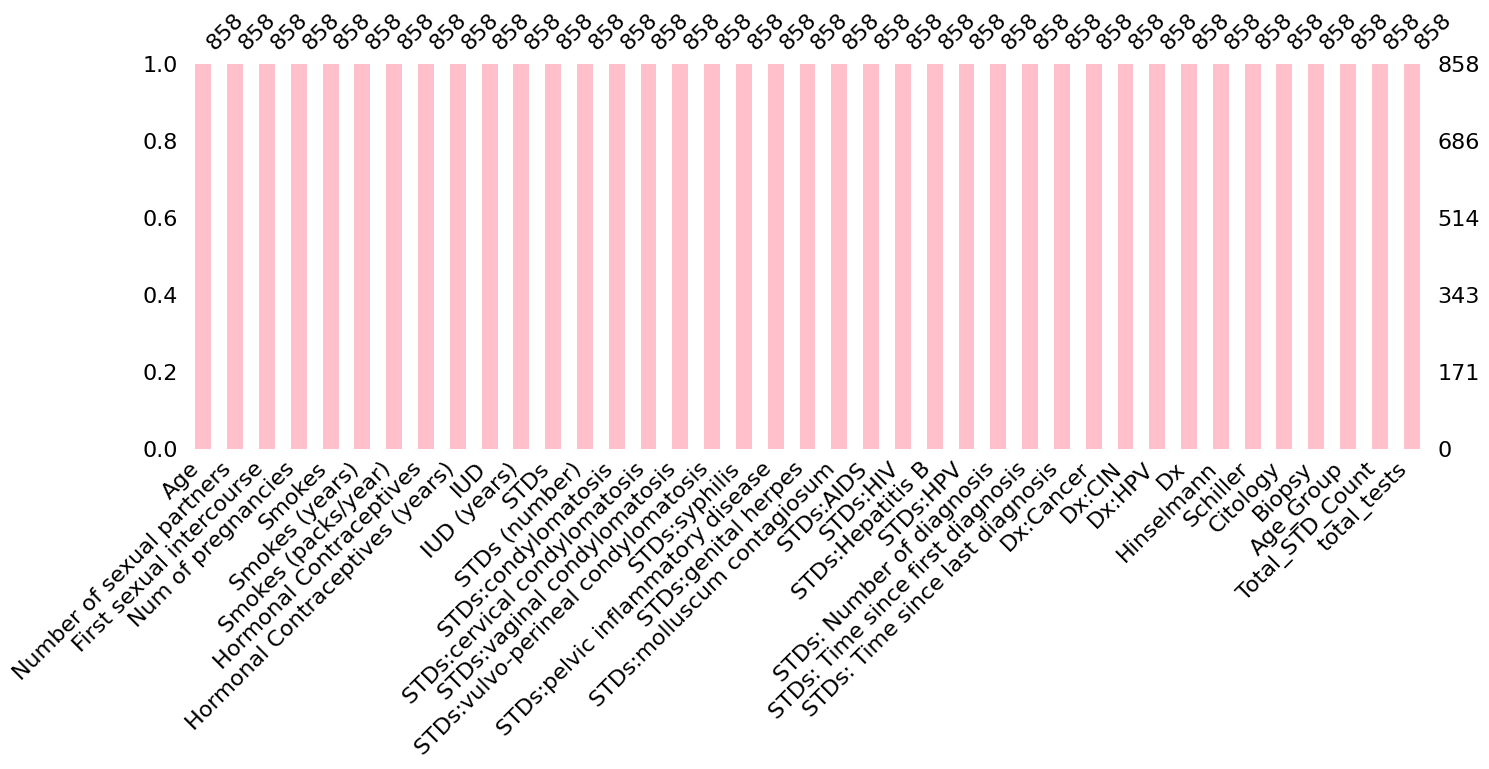

In [15]:
msno.bar(cancer_dataframe, figsize = (16,5),color = "pink")
plt.show()

<br></br>
<h3><b> Data Visualization</b></h3>

In [16]:
# Let's visulaize the distribution of age
age_dist = px.histogram(cancer_dataframe, x="Age", marginal="box", color_discrete_sequence=["palevioletred"])
age_dist.update_layout(title="Age distribution")
age_dist.show()

In [17]:
diagnoses_num_partner_compare_cols = ['Dx:Cancer',
                                      'Dx:HPV',
                                      "Number of sexual partners",]
corr_matrix = cancer_dataframe[diagnoses_num_partner_compare_cols].corr()
diagnoses_num_partner_heatmap = px.imshow(corr_matrix,
                              aspect="auto",
                              color_continuous_scale="gnbu",
                              text_auto=True)
diagnoses_num_partner_heatmap.show()

<br></br>
<h3><b> Imbalance Data</b></h3>

In [18]:
dx_cancer = px.histogram(cancer_dataframe, y="Dx:Cancer")
dx_cancer.update_layout(bargap=0.2)
dx_cancer.update_layout(title = "Imbalanced Classes")
dx_cancer.show()

In [19]:
X = cancer_dataframe.drop(["Dx:Cancer", "Age_Group"], axis=1)
y = cancer_dataframe["Dx:Cancer"].copy()

In [20]:
# Let's initialize ADASYN sample
adaptive_sampling = ADASYN(random_state=42)

# Let's apply ADASYN to resample the features (X) and target (y)
features_resampled, target_resampled = adaptive_sampling.fit_resample(X, y)

cancer_dataframe = features_resampled.join(target_resampled, how='outer')


In [21]:
# Let's apply the age categorization function to each age in the dataframe
cancer_dataframe["Age_Group"] = cancer_dataframe["Age"].apply(categorize_age)

In [22]:
# Let's create a histogram to visualize the distribution of Dx:Cancer in the dataset
cancer_diagnosis_distribution = px.histogram(cancer_dataframe, y="Dx:Cancer", title="Distribution of Cancer Diagnosis")
cancer_diagnosis_distribution.update_layout(
    bargap=0.2,  # Adjust the gap between bars
    title_text="Distribution of Cancer Diagnosis - Balanced Classes"  # Update the title to provide more context
)

# Let's display the histogram
cancer_diagnosis_distribution.show()

In [23]:
def prepare_data(df, target, stratify_col, test_ratio=0.2, random_seed=62, cols_to_remove=None):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=random_seed)
    for train_idx, test_idx in split.split(df, df[stratify_col]):
        train_set = df.loc[train_idx]
        test_set = df.loc[test_idx]

    if cols_to_remove:
        for set_ in (train_set, test_set):
            set_.drop(cols_to_remove, axis=1, inplace=True)

    X_train = train_set.drop(target, axis=1)
    y_train = train_set[target].copy()

    X_test = test_set.drop(target, axis=1)
    y_test = test_set[target].copy()

    return X_train, y_train, X_test, y_test


cols_to_drop = ["Age_Group", "Total_STD_Count", "total_tests"]
X_train, y_train, X_test, y_test = prepare_data(cancer_dataframe, "Dx:Cancer", "Age_Group", cols_to_remove=cols_to_drop)


<br></br>
<h3><b>PCA and Model</b></h3>

In [24]:
def preprocess_features(feature_data, n_pca_components=13, pipeline=None):
    if pipeline is None:
        # Define and fit a new preprocessing pipeline if none is provided
        pipeline = Pipeline([
            ("data_scaler", RobustScaler()),
            ("dimensionality_reducer", PCA(n_components=n_pca_components))
        ])
        transformed_features = pipeline.fit_transform(feature_data)
    else:
        # Use the provided pipeline to transform the data
        transformed_features = pipeline.transform(feature_data)

    return transformed_features, pipeline

X_train_preprocessed, training_pipeline = preprocess_features(X_train, n_pca_components=13)
X_test_preprocessed, _ = preprocess_features(X_test, pipeline=training_pipeline)

In [25]:
from sklearn.pipeline import make_pipeline

# Let's define a parameter grid for hyperparameter tuning
parameter_grid = {'logisticregression__C': np.logspace(-5, 8, 15)}

# Let's create a pipeline that first scales the data
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Set up GridSearchCV with the pipeline
grid_search = GridSearchCV(pipeline, parameter_grid, cv=10, refit=True)

# Let's fit the grid search to the training data
logistic_regression_cv = grid_search.fit(X_train_preprocessed, y_train)

<br></br>
<h3><b>Random Forest Classifier</b></h3>

In [26]:
random_forest_classifier = RandomForestClassifier(n_estimators=2500, max_leaf_nodes=2, n_jobs=-1,
                                 max_features="sqrt")

<br></br>
<h3><b>KNN Classifier</b></h3>

In [27]:
# Let's define KNNClassifier

knn_classifier = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": list(np.arange(1, 100, 2))}
knn_classifier_cv = GridSearchCV(knn_classifier, knn_param_grid, cv=10,refit=True).fit(X_train_preprocessed,y_train)
knn_classifier_cv = KNeighborsClassifier(**knn_classifier_cv.best_params_)

<br></br>
<h3><b>SVM Classifier</b></h3>

In [28]:
# Let's define SVM Classifier
svm_classifier = SVC()
svc_param_grid = {"C": np.logspace(-3, 2, 6), "gamma": np.logspace(-3, 2, 6), }
svm_classifier_cv = GridSearchCV(svm_classifier, svc_param_grid, cv=5)

In [29]:
col_names = ["Classifier Name", "Accuracy Score", "Precision Score",
             "Recall Score", "F1 Score"]
summary_df = pd.DataFrame(columns=col_names)

est_name = []
est_acc = []
precision_score = []
recall_score = []
f1score = []
est_conf_matrix = []

estimators = [
    ("LogisticRegression", logistic_regression_cv),
     ("RandomForestClassifier ", random_forest_classifier),
    ("KNeighborsClassifier", knn_classifier_cv),
    ("SupportVectorClassifier", svm_classifier_cv)]

for i in range(0, len(estimators)):
    clf_name = estimators[i][0]
    clf = estimators[i][1]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # print(pd.crosstab(y_test,y_pred,rownames=["Actual"],colnames=["predicted"],margins=True))
    est_name.append(estimators[i][0])
    est_acc.append(accuracy_score(y_test, y_pred))
    scores = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    precision_score.append(scores[0])
    recall_score.append(scores[1])
    f1score.append(scores[2])
    est_conf_matrix.append(confusion_matrix(y_test,y_pred))


summary_df[col_names[0]] = est_name
summary_df[col_names[1]] = est_acc
summary_df[col_names[2]] = precision_score
summary_df[col_names[3]] = recall_score
summary_df[col_names[4]] = f1score

<br></br>
<h3><b>Results</b></h3>

In [30]:
# Let's print the resuts of LogisticRegression, Random Forest, KNN and SVC
summary_df

,Classifier Name,Accuracy Score,Precision Score,Recall Score,F1 Score
0,LogisticRegression,1.000000,1.000000,1.000000,1.000000
1,RandomForestClassifier,0.991071,0.991226,0.991071,0.991070
2,KNeighborsClassifier,0.955357,0.959057,0.955357,0.955292
3,SupportVectorClassifier,1.000000,1.000000,1.000000,1.000000


In [31]:
# Define a list of color scales for visual variety
unique_color_scales = ["agsunset", "teal", "purples", "viridis"]

# Iterate over the confusion matrices and their corresponding names
for index, conf_matrix in enumerate(est_conf_matrix):
    # Generate a heatmap for each confusion matrix
    heatmap_visual = px.imshow(conf_matrix, aspect="auto", text_auto=True,
                               color_continuous_scale=unique_color_scales[index % len(unique_color_scales)])

    # Customize the layout with dynamic titles and axis labels
    heatmap_visual.update_layout(title=est_name[index])
    heatmap_visual.update_xaxes(title="Predicted Labels")
    heatmap_visual.update_yaxes(title="Actual Labels")

    # Display the heatmap
    heatmap_visual.show()